![title](img/logo.png)
# Biometrics System Concepts
## Assignment 1: Evaluating performance of biometric systems
<b>Name</b>: Deniz SOYSAL|
<b>Student-nr</b>: r0875700 |
<b>Date</b>: March 25, 2021
---

In this assignment we focus on evaluating the performance of any biometric system in a verification and identification setting. 

Before you get started you should be able to properly distinguish verification from identification and know the corresponding validation procedures. If this is not the case for you yet, **review the lecture notes!** We will give a short recap to refresh your memory: 
* **VERIFICATION** (a.k.a. authentication): Authenticating a claimed identity (is this person who he/she claims to be?).

* **IDENTIFICATION**: Associate a particular individual with an identity (who is this unidentified individual?).

This document is structured as follows:

- [I. Reading the data](#I.-Reading-the-data)
- [II. Validation of verification system](#II.-Validation-of-verification-system)
- [III. Validation of identification system](#III.-Validation-of-identification-system)
- [IV. Assignment Instructions](#IV.-Assignment-Instructions)


Code examples will be provided below. You can and are invited to adapt these at your will (different parameter settings, different choices of alogorithmic components). The code examples in this assignment are just sekeleton code,  **adapt where needed! And try to keep things structured!** 

In [395]:
# Install and import the required python packages to run this notebook. Feel free to add more packages whenever needed.

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#seaborn more suited for datagframe 
import seaborn as sns

#library with a lot of functions to compute FPR, FNR, plot DEC, ROC, ...
#see https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn import metrics

# package for reading xml files
import xml.etree.ElementTree as ET

import os

# package for data analysis with fast and flexible data structures
import pandas as pd


# package to show a nice graphical progress-bar for lengthy calculations
# docu and installation on https://tqdm.github.io
# if you have difficulties installing this package: 
# - make sure your jupyter lab is up to date
# - https://github.com/tqdm/tqdm/issues/394#issuecomment-384743637
# - consider just leaving it out (just remove the 'tqdm_notebook' in the code)
from tqdm.notebook import tqdm as tqdm_notebook

# import local modules for reading and converting BSSR1 fingerprint score data
import src.BSSR1 as BSSR1

import pickle

#to print beautiful tables
from beautifultable import BeautifulTable

#to print full dataframe
from IPython.core.display import HTML




<div class="alert alert-block alert-info">
<b>Tip:</b> 
Many operations have already been implemented in <a href="https://docs.scipy.org/doc/numpy/index.html">SciPy</a>, feel free to use them or any other unless explicitely stated not to in the assignment.</div>

## I. Reading the data
In this assignment we focus on the validation of a pre-exising biometric system. We will make use of actual predicted fingerprint similarity scores, from the left and right index fingers. This bypasses all steps of preprocessing, feature extraction and matching and allows us to concentrate on the score evaluation procedures. The scores are the result of comparing an enrolled user's image with that of the same (genuine scores) or another user (impostor scores). The data (biometrics scores set BSSR1) are made available through the American National Institute of Standards and Technologies [(NIST)](https://www.nist.gov/itl/iad/image-group/nist-biometric-scores-set-bssr1). They are provided as part of your assignment folder in the `data/fing-x-fing` subfolder. 

In this code example we will compare the performance of a biometric system that was based on the right index finger to a biometric system based on the left index finger. These systems are referred to as `ri` and `li` respectively in both code and text.  

### 1.1. Loading the similarity matrix and reading the genuine and impostor scores
We provide you with the code to read the scores from the files (normally you can leave this code as-is).

The code consits of 2 steps that are executed for both the `ri` and `li` system: 
1. Scores are converted to similarity matrices. To simplify the task we have provided you with the similarity matrices. You need to load the similarity matrices with the genuine scores on the diagonal and the impostor scores on the off-diagonal elements.  
2. Convert the original scores to a linear list of scores with associated labels of genuine or impostor (simplifies use of [scikit-learn](https://scikit-learn.org/stable/index.html))



In [396]:
# STEP 1: loading the similarity matrices for left and right index fingers
with open('./data/li_similarity_matrix.pickle', 'rb') as f:
    li_similarity_matrix = pickle.load(f)
with open('./data/ri_similarity_matrix.pickle', 'rb') as f:
    ri_similarity_matrix = pickle.load(f)


In [397]:
# STEP 2: convert to genuine and impostor scores, the *_genuine_id provides a mask for the genuine scores
li_genuine_id, li_scores = BSSR1.sim2scores(li_similarity_matrix)
ri_genuine_id, ri_scores = BSSR1.sim2scores(ri_similarity_matrix)

print(li_genuine_id)
print("when 1--> geunine, when 0 --> impostor")
print(li_scores)
print("correspond to matching scores")

[1. 1. 1. ... 0. 0. 0.]
when 1--> geunine, when 0 --> impostor
[0.18320611 0.27099237 0.0648855  ... 0.03053435 0.02290076 0.01145038]
correspond to matching scores


In [398]:
#let's work with dataframes
columns=['li_genuine_id', 'li_scores', 'ri_genuine_id', 'ri_scores']
data_list = [li_genuine_id, li_scores, ri_genuine_id, ri_scores]
df = pd.DataFrame(data_list,index=columns).transpose()
print(df)

        li_genuine_id  li_scores  ri_genuine_id  ri_scores
0                 1.0   0.183206            1.0   0.125874
1                 1.0   0.270992            1.0   0.353147
2                 1.0   0.064885            1.0   0.101399
3                 1.0   0.041985            1.0   0.209790
4                 1.0   0.377863            1.0   0.367133
...               ...        ...            ...        ...
999995            0.0   0.011450            0.0   0.013986
999996            0.0   0.030534            0.0   0.000000
999997            0.0   0.030534            0.0   0.024476
999998            0.0   0.022901            0.0   0.010490
999999            0.0   0.011450            0.0   0.010490

[1000000 rows x 4 columns]


<div class="alert alert-block alert-info">
<b>Tip:</b> 
In this assignment we focus only on evaluating biometric systems. It is in your best interest to write your code such that it can easily be reused in the upcoming assignments, where you will have to develop entire biometric system pipelines.</div>

## II. Validation of verification system

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)

The performance of a verification scenario can be expressed in a number of ways (see [Jain et al.][1] section 1.4.1.1 for more information). In essence one has a binary classification problem: is it the claimed identity or not? 

We denote our classes as:
<ol start="0">
  <li>Impostor (False),</li>
  <li>Genuine (True).</li>
</ol>

Furthermore, we represent the set of scores as s, the imposter event as $I$ and a genuine event as $G$.

### 1. Evaluation using FMR, FRR, ROC and Precision/Recall curves

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)



#### 1.1 Genuine and impostor score distributions
Given the genuine and impostor scores (from section I), we can plot the imposter $p(s | I)$ and genuine $p(s | G)$ distribution to gain some first insights in the system. The result should look something like this:

<p align="center">
    <img src="img/ScoreDistributions.png" width="250" height="auto"/>
</p>


<div class="alert alert-block alert-success">
<b>Q1: </b> Score distributions
<ul>
  <li>Plot the genuine and impostor score distributions in a single plot.</li>
  <li>Do you need to normalize the distributions? Why (not)?</li>
  <li>Describe qualitatively this combined plot (hint: limit the score range for better understanding)</li>
</ul>  
</div>

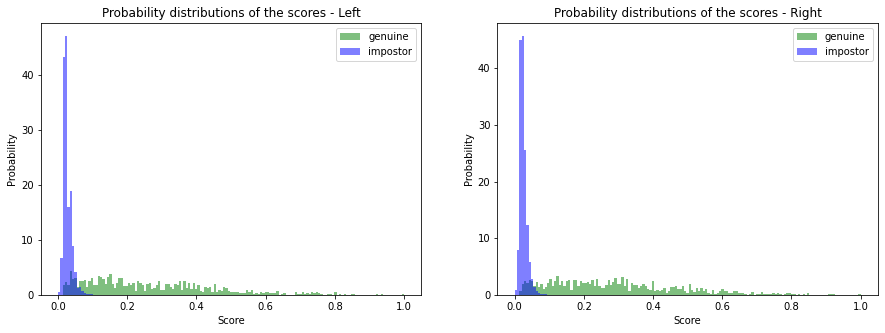

In [399]:
"""Plot the genuine and imposter score distributions."""
#genuine scores are the score where genuine_id == 1
#impostor scores are the score where impostor_id == 1

li_genuine_scores = df.loc[df['li_genuine_id'] == 1, 'li_scores']
li_impostor_scores = df.loc[df['li_genuine_id'] == 0, 'li_scores']
ri_genuine_scores = df.loc[df['ri_genuine_id'] == 1, 'ri_scores']
ri_impostor_scores = df.loc[df['ri_genuine_id'] == 0, 'ri_scores']

###############################
####TO COMPLETE################
###############################


fig, axis = plt.subplots(1,2,figsize=(15,5))
bins = np.linspace(0, 1, 150)


"""
LEFT FINGER
"""

axis[0].hist(li_genuine_scores,color='g',density=True,alpha=0.5,bins = bins,label = "genuine") 
axis[0].hist(li_impostor_scores, color='b',density=True,alpha=0.5,bins = bins,label = "impostor") 
axis[0].title.set_text("Probability distributions of the scores - Left")
axis[0].legend()
axis[0].set_xlabel('Score')
axis[0].set_ylabel('Probability')

"""
RIGHT FINGER
"""
axis[1].hist(ri_genuine_scores,color='g',density=True,alpha=0.5,bins = bins,label = "genuine") 
axis[1].hist(ri_impostor_scores, color='b',density=True,alpha=0.5,bins = bins,label = "impostor") 
axis[1].title.set_text("Probability distributions of the scores - Right") 
axis[1].legend()
axis[1].set_xlabel('Score')
axis[1].set_ylabel('Probability')

plt.savefig('report/images/distribution.png')

#### 2. FMR, FRR and Receiver Operating Characteristic (ROC) curve

The 'false accept' and 'false reject' regions in the illustration above are quantified using the False Match/Acceptance Rates (FMR/FAR) and False Non-Match/Rejections Rates (FNMR/FRR). The FMR and FNMR can easily be computed given the previously calculated probability distributions and a threshold value $\eta$. Practically this boils down to a counting problem, having $\mathcal{I}$ the indicator function (return 1 if x is true, else 0) we can compute:
$$
FMR(\eta) = p(s \geq \eta | I) \approx \frac{1}{|I|} \sum_{s \in I} \mathcal{I}(s \geq \eta),
$$
$$
FRR(\eta) = p(s < \eta | G) \approx \frac{1}{|G|} \sum_{s \in G} \mathcal{I}(s < \eta).
$$

We can also compute the Genuine Acceptance Rate (GAR)/True Match Rate (TMR) as:
$$
GAR(\eta) = p(s \geq \eta | G) = 1 - FRR(\eta).
$$

Note that choosing a threshold is always a tradeof between FMR and FNMR. <br>
<img src="img/FAR_FRR.png" width="300" height="auto" align="center"/>

To observe the impact of the threshold value, one often plots a [Receiver Operating Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve. Usually in these curves the GAR/TMR is plotted against the FMR for different decision threshold values $\eta$. For those familiar with binary classification systems outside of the biometrics literature; the GAR/TMR is often referred to as the True Positive Rate (TPR), sensitivity or recall and FMR is also known as the False Positive Rate (FPR) or the False Accept Rate (FAR). 

<img src="img/ROC.png" width="700" height="auto" align="center"/>

<div class="alert alert-block alert-success">
<b>Q2: </b> ROC Curves
<ul>
    <li>Calculate FPR, TPR from the matching scores.</li>
    <li>Plot FAR and FRR as a function of matching scores.</li>
    <li>Plot the ROC curve. Plot for linear and logarithmic scale if needed. What do you observe?</li>
    <li>Plot the Detection Error Trade-off (DET) curve. How does it compare to ROC?</li>
</ul>  
</div>


<div class="alert alert-block alert-info">
<b>Tip:</b> 
We highly recommend you use the <a href="https://scikit-learn.org/stable/index.html">scikit-learn</a> package, it contains standard and advanced routines for machine learning, including classificaton and validation algorithms.
</div>

In [400]:

"""Calculate FPR, TPR from the matching scores """

#we will use the sklearn.metrics.det_curve function
#that returns fpr, fnrn and thresholds
#it is a function that test different values of threshold
#and compute fpr and fnr at each of these threshold


"""
LEFT INDEX

"""

y_score_li  = df['li_scores']
y_true_li = df['li_genuine_id']
fpr_li, fnr_li, thresholds_li = metrics.det_curve(y_true_li, y_score_li)
tpr_li = 1 - fnr_li 

"""
RIGHT INDEX

"""

y_score_ri  = df['ri_scores']
y_true_ri = df['ri_genuine_id']
fpr_ri, fnr_ri, thresholds_ri = metrics.det_curve(y_true_ri, y_score_ri)
tpr_ri = 1 - fnr_ri 


Let's alsos see if we can compute the FPR and TPR from scratch :

(we will not use these functions in the notebook) 

In [401]:
"""Calculate FPR, TPR from the matching scores, from SCRATCH, with a fixed threshold """

def computeFPR(id_name, id_value, score,threshold=0.1):
    
    #FPR = (false positive)/(sum of false positive and true negative)
    #false positive = score > threshold  AND genuine_id= 0
    #true negative = score < threshold  AND genuine_id= 0
    
    false_positive =  df.loc[(df[id_name] == id_value) & (df[score] > threshold), score]
    false_positive_count = false_positive.shape[0]
    true_negative =  df.loc[(df[id_name] == id_value) & (df[score] < threshold), score]
    true_negative_count = true_negative.shape[0]
    
    FPR = false_positive_count / (false_positive_count  + true_negative_count)
    
    return FPR

def computeTPR(id_name, id_value, score,threshold=0.1):
    
    #TPR = (false negative)/(sum of true positive and false negative)
    #false positive = score > threshold  AND genuine_id= 0
    #true negative = score < threshold  AND genuine_id= 0
    
    false_negative =  df.loc[(df[id_name] == id_value) & (df[score] < threshold), score]
    false_negative_count = false_negative.shape[0]
    true_positive =  df.loc[(df[id_name] == id_value) & (df[score] > threshold), score]
    true_positive_count = true_positive.shape[0]
    
    TPR = false_negative_count / (false_negative_count  + true_positive_count)
    
    return TPR

li_FPR = computeFPR('li_genuine_id', 0, 'li_scores',threshold=0.1)   
ri_FPR = computeFPR('ri_genuine_id', 0, 'ri_scores',threshold=0.1)  

li_TPR = computeFPR('li_genuine_id', 1, 'li_scores',threshold=0.1)   
ri_TPR = computeFPR('ri_genuine_id', 1, 'ri_scores',threshold=0.1)  

print(li_FPR,ri_FPR,li_TPR,ri_TPR)

0.0003873873873873874 0.00025925925925925926 0.784 0.841


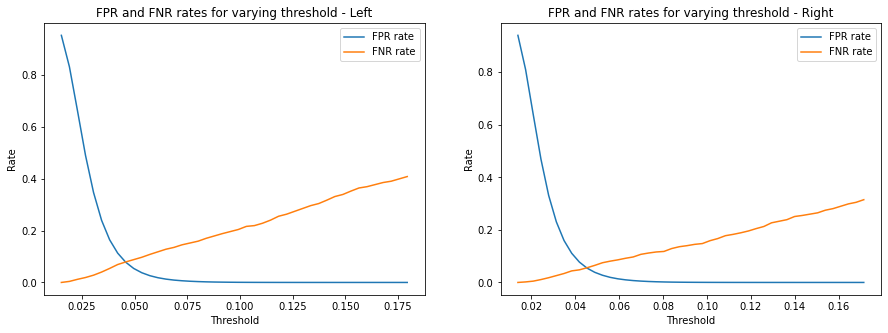

In [402]:
"""Plot FAR and FRR as a function of the decision threshold."""
# FAR <=> FPR
# FRR <=> FNR <=> FN/P <=> 1-TPR



fig, axis = plt.subplots(1,2,figsize=(15,5))

"""
LEFT FINGER
"""

axis[0].plot(thresholds_li,fpr_li,label="FPR rate") 
axis[0].plot(thresholds_li,fnr_li,label="FNR rate") 
axis[0].title.set_text("FPR and FNR rates for varying threshold - Left") 
axis[0].legend()
axis[0].set_xlabel('Threshold')
axis[0].set_ylabel('Rate')

"""
RIGHT FINGER
"""

axis[1].plot(thresholds_ri,fpr_ri,label="FPR rate") 
axis[1].plot(thresholds_ri,fnr_ri,label="FNR rate") 
axis[1].title.set_text("FPR and FNR rates for varying threshold - Right") 
axis[1].legend()
axis[1].set_xlabel('Threshold')
axis[1].set_ylabel('Rate')


plt.savefig('report/images/FAR_FRR.png')

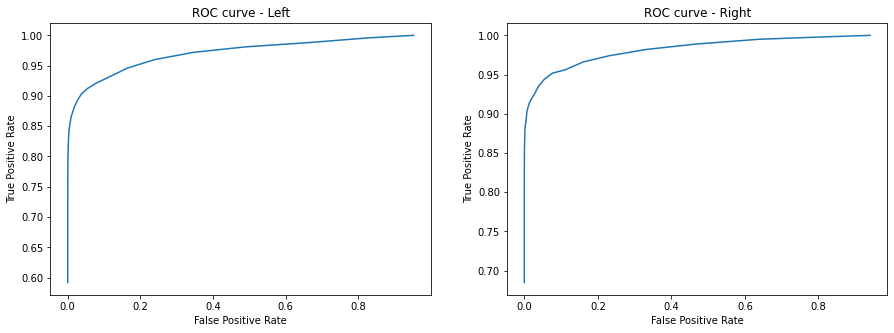

In [403]:
"""plot the ROC curve (TPR against the FPR for different threshold values)"""



fig, axis = plt.subplots(1,2,figsize=(15,5))

"""
LEFT FINGER
"""

roc_li = metrics.RocCurveDisplay(fpr=fpr_li,tpr=tpr_li)
roc_li.plot(ax=axis[0])
axis[0].title.set_text("ROC curve - Left") 
axis[0].set_xlabel('False Positive Rate')
axis[0].set_ylabel('True Positive Rate')

"""
RIGHT FINGER
"""

roc_ri = metrics.RocCurveDisplay(fpr=fpr_ri,tpr=tpr_ri)
roc_ri.plot(ax=axis[1])
axis[1].title.set_text("ROC curve - Right") 
axis[1].set_xlabel('False Positive Rate')
axis[1].set_ylabel('True Positive Rate')



plt.savefig('report/images/ROC.png')

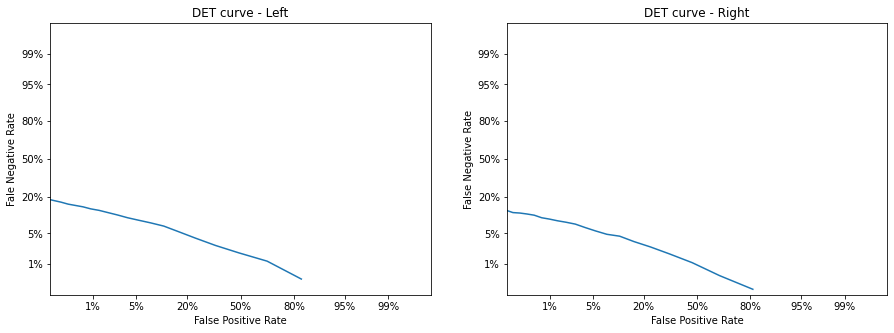

In [404]:
"""plot the DET curve (FRR (=1-tpr) against the FAR for different threshold values)"""

# FAR <=> FPR
# FRR <=> FNR <=> FN/P <=> 1-TPR




fig, axis = plt.subplots(1,2,figsize=(15,5))

"""
LEFT FINGER
"""

det_li = metrics.DetCurveDisplay(fpr=fpr_li,fnr=fnr_li)
det_li.plot(ax=axis[0])
axis[0].title.set_text("DET curve - Left") 
axis[0].set_xlabel('False Positive Rate')
axis[0].set_ylabel('Fale Negative Rate')

"""
RIGHT FINGER
"""

det_ri = metrics.DetCurveDisplay(fpr=fpr_ri,fnr=fnr_ri)
det_ri.plot(ax=axis[1])
axis[1].title.set_text("DET curve - Right") 
axis[1].set_xlabel('False Positive Rate')
axis[1].set_ylabel('False Negative Rate')


plt.savefig('report/images/DET.png')

#### 3. F1 and accuracy as metrics

While biometric systems are, traditionally, evaluated using FMR and FRR and ROC/DET curves, we can also have a look at traditional [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) such as classification accuracy (or error) and F1 measure. 

<div class="alert alert-block alert-success">
<b>Q3: </b> Classification Metrics
<ul>
    <li>Plot F1 and accuracy as a function of the decision thresholds on the similarity score.</li>
    <li>Calculate the threshold and accuracy for which F1 is maximal. Is it an interesting operating point?</li>
    <li>Do the same for the classification error (accuracy). Is there a difference?</li>
    <li>Is accuracy a good performance metric in this case?</li>
</ul>  
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> 
We highly recommend you use the <a href="https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics">scikit-learn classification metrics</a> to assist.
</div>


In [405]:
"""function to compute the accuracy"""


#we know that accuracy = (TP + TN / whole data) = TP + TN + FP + FN)

def compute_accuracy(df,id_name,thresholds, score):
    accuracies = []
    number_of_samples = df.shape[0]
    for tresh in thresholds:
        true_positive =  df.loc[(df[id_name] == 1) & (df[score] > tresh), score]
        true_positive_count = true_positive.shape[0]
        true_negative =  df.loc[(df[id_name] == 0) & (df[score] < tresh), score]
        true_negative_count = true_negative.shape[0]
        accuracy = (true_positive_count+true_negative_count)/number_of_samples
        accuracies.append(accuracy)
    return accuracies

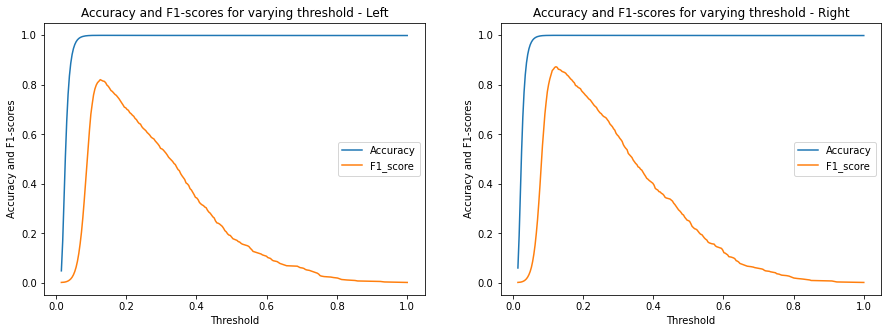

In [406]:
"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
# Hint: evaluating for ± 50 threshold values should suffice

#metrics has the function f1_score but it takes too much time to run
#let's deduce f1_score from precision and recall instead 

fig, axis = plt.subplots(1,2,figsize=(15,5))

"""
LEFT FINGER
"""
precision_li, recall_li, PR_thresholds_li = metrics.precision_recall_curve(y_true_li,y_score_li)
#thresholds has a value less than precision and recall when using precision_recall_curve (bug ?)
#so, let's remove one value from precision and recall
precision_li, recall_li = precision_li[:-1], recall_li[:-1]
f1_score_li = 2 *(precision_li*recall_li)/(precision_li+recall_li)

accuracies_li = compute_accuracy(df,'li_genuine_id',PR_thresholds_li,'li_scores')

axis[0].plot(PR_thresholds_li,accuracies_li,label="Accuracy") 
axis[0].plot(PR_thresholds_li,f1_score_li,label="F1_score") 
axis[0].title.set_text("Accuracy and F1-scores for varying threshold - Left") 
axis[0].legend()
axis[0].set_xlabel('Threshold')
axis[0].set_ylabel('Accuracy and F1-scores')
"""
RIGHT FINGER
"""
precision_ri, recall_ri, PR_thresholds_ri = metrics.precision_recall_curve(y_true_ri,y_score_ri)
#thresholds has a value less than precision and recall when using precision_recall_curve (bug ?)
#so, let's remove one value from precision and recall
precision_ri, recall_ri = precision_ri[:-1], recall_ri[:-1]
f1_score_ri = 2 *(precision_ri*recall_ri)/(precision_ri+recall_ri)

accuracies_ri = compute_accuracy(df,'ri_genuine_id',PR_thresholds_ri,'ri_scores')

axis[1].plot(PR_thresholds_ri,accuracies_ri,label="Accuracy") 
axis[1].plot(PR_thresholds_ri,f1_score_ri,label="F1_score") 
axis[1].title.set_text("Accuracy and F1-scores for varying threshold - Right") 
axis[1].legend()
axis[1].set_xlabel('Threshold')
axis[1].set_ylabel('Accuracy and F1-scores')


plt.savefig('report/images/F1_accuracy.png')

In [407]:
"""Calculate the threshold for which F1 is maximal."""


"""
LEFT FINGER
"""



#create dataframe of f1 score 
f1_df_li = pd.DataFrame([f1_score_li,PR_thresholds_li],index=["f1_score_li","thresholds_li"]).transpose()
#find maximum row 
max_row_li = f1_df_li['f1_score_li'].idxmax()
#find corresponding threshold 
f1_max_threshold_li = f1_df_li["thresholds_li"][max_row_li]
#and corresponding f1 score
f1_max_score_li = f1_df_li["f1_score_li"][max_row_li]

"""
RIGHT FINGER
"""

#create dataframe of f1 score 
f1_df_ri = pd.DataFrame([f1_score_ri,PR_thresholds_ri],index=["f1_score_ri","thresholds_ri"]).transpose()
#find maximum row 
max_row_ri = f1_df_ri['f1_score_ri'].idxmax()
#find corresponding threshold 
f1_max_threshold_ri = f1_df_ri["thresholds_ri"][max_row_ri]
#and corresponding f1 score
f1_max_score_ri = f1_df_ri["f1_score_ri"][max_row_ri]


table = BeautifulTable()
table.rows.append([f1_max_threshold_li, f1_max_score_li])
table.rows.append([f1_max_threshold_ri, f1_max_score_ri])
table.rows.header = ["Left Finger", "Right Finger"]
table.columns.header = ["Corresponding Threshold", "Maximum f1-score"]
print(table)


+--------------+-------------------------+------------------+
|              | Corresponding Threshold | Maximum f1-score |
+--------------+-------------------------+------------------+
| Left Finger  |          0.126          |      0.821       |
+--------------+-------------------------+------------------+
| Right Finger |          0.122          |      0.873       |
+--------------+-------------------------+------------------+


In [408]:
"""Do the same for the classification error (or accuracy)"""

"""Calculate the threshold for which accuracy is maximal."""


"""
LEFT FINGER
"""



#create dataframe of accuracy 
accuracies_df_li = pd.DataFrame([accuracies_li,thresholds_li],index=["accuracies_li","thresholds_li"]).transpose()
#find maximum row 
max_row_accuracies_df_li = accuracies_df_li['accuracies_li'].idxmax()
#find corresponding threshold 
max_threshold_accuracies_df_li = accuracies_df_li["thresholds_li"][max_row_accuracies_df_li]
#find corresponding max accuracy
max_accuracy_df_li = accuracies_df_li["accuracies_li"][max_row_accuracies_df_li]

"""
RIGHT FINGER
"""

#create dataframe of accuracy 
accuracies_df_ri = pd.DataFrame([accuracies_ri,thresholds_ri],index=["accuracies_ri","thresholds_ri"]).transpose()
#find maximum row 
max_row_accuracies_df_ri = accuracies_df_ri['accuracies_ri'].idxmax()
#find corresponding threshold 
max_threshold_accuracies_df_ri = accuracies_df_ri["thresholds_ri"][max_row_accuracies_df_ri]
#find corresponding max accuracy
max_accuracy_df_ri = accuracies_df_ri["accuracies_ri"][max_row_accuracies_df_ri]


table = BeautifulTable()
table.rows.append([max_threshold_accuracies_df_li, max_accuracy_df_li])
table.rows.append([max_threshold_accuracies_df_ri, max_accuracy_df_ri])
table.rows.header = ["Left Finger", "Right Finger"]
table.columns.header = ["Corresponding Threshold", "Maximum accuracy"]
print(table)

+--------------+-------------------------+------------------+
|              | Corresponding Threshold | Maximum accuracy |
+--------------+-------------------------+------------------+
| Left Finger  |          0.134          |       1.0        |
+--------------+-------------------------+------------------+
| Right Finger |          0.122          |       1.0        |
+--------------+-------------------------+------------------+


#### 4. AUC and EER as summary measures

The overall performance (over all threshold settings) is typically expressed through:

* The Area Under the Curve (AUC) (with TPR((y-axis) vs FPR (x-axis))

<img src="img/AUC.png" width="250" height="auto"/>

The AUC can be used to compare different systems. The larger this number, the better.
However, since it is a summary measure, always inspect the full ROC curve to make decisions about performance given operating conditions (in wich FRR, FAR regime to work e.g.).

* The Equal Error Rate (EER), which is the point on the ROC-curve where FAR(FMR) equals FRR (1-TAR). A lower EER value indicates better performance. 

<img src="img/EER.png" width="300" height="300"/>

<div class="alert alert-block alert-success">
<b>Q4: </b> AUC, EER and alternatives
<ul>
    <li>Calculate ROC AUC. Is this a good metric? What does it reveal about the system? </li>
    <li>Calculate (by approximation) the EER and plot it on the FAR-FRR curve. Is this a good peration point?</li>
    <li>Calculate the decision threshold for which the sum of FRR and FAR is minimal. Is this point similar to the total classification error?</li> 
    <li>Can you suggest other strategies that give you an "optimal" performance? Calculate and discuss their (de)merits.</li>
</ul>  
</div>


In [409]:
"""Calculate the ROC AUC."""
#the function metrics.auc(y_true, y_score) allows us to compute the ROC AUC, based on the fpr vector and the tpr vector 
ROC_AUC_li = metrics.roc_auc_score(y_true_li, y_score_li)
ROC_AUC_ri = metrics.roc_auc_score(y_true_ri, y_score_ri)

table = BeautifulTable()
table.rows.append([ROC_AUC_li])
table.rows.append([ROC_AUC_ri])
table.rows.header = ["Left Finger", "Right Finger"]
table.columns.header = ["ROC AUC"]
print(table)


+--------------+---------+
|              | ROC AUC |
+--------------+---------+
| Left Finger  |  0.971  |
+--------------+---------+
| Right Finger |  0.983  |
+--------------+---------+


     fpr_li  fnr_li  thresholds_li
8  0.077935   0.079       0.045802
     fpr_ri  fnr_ri  thresholds_ri
9  0.054403   0.056       0.045455


Text(0, 0.5, 'FRR')

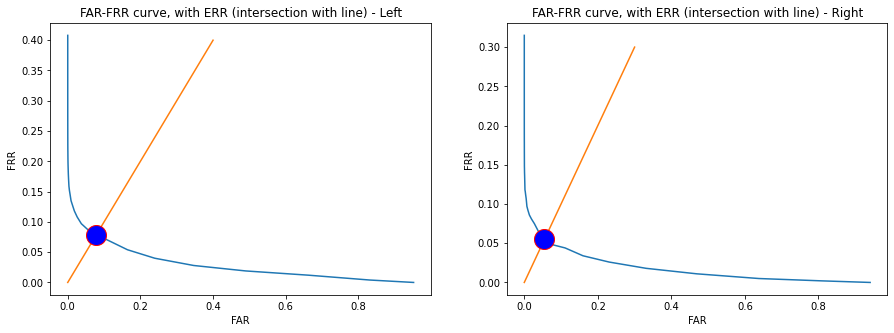

In [441]:
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve."""
# hints:
#  - avoid using a library that directly computes the EER for this assignment 

#EER is at the threshold where FAR (False acceptance rate, or FPR) = FRR (false rejection rate, or FNR)

fig, axis = plt.subplots(1,2,figsize=(15,5))
from intersect import intersection

x_li, y_li = intersection(np.linspace(0,1,200),np.linspace(0,1,200), fpr_li, fnr_li)

"""
LEFT FINGER
"""
df_to_find_EER_li = pd.DataFrame([fpr_li,fnr_li,thresholds_li],index = ["fpr_li","fnr_li","thresholds_li"]).transpose()

#select row where fpr_li is the closest to fnr_li
EER_row_li = df_to_find_EER_li.iloc[(df_to_find_EER_li["fpr_li"]-df_to_find_EER_li["fnr_li"]).abs().argsort()[:1]]
print(EER_row_li)

#plot the FAR-FRR curve :
axis[0].plot(fpr_li,fnr_li)
#Plot a diagonal line : indeed, everywhere on this line, FAR = FRR ! 
axis[0].plot([0, 0.4], [0,0.4])
axis[0].plot([EER_row_li["fpr_li"]], [EER_row_li["fnr_li"]], marker="o", markersize=20, markeredgecolor="red", markerfacecolor="blue")
axis[0].title.set_text("FAR-FRR curve, with ERR (intersection with line) - Left")
axis[0].set_xlabel('FAR')
axis[0].set_ylabel('FRR')



"""
RIGHT FINGER
"""
df_to_find_EER_ri = pd.DataFrame([fpr_ri,fnr_ri,thresholds_ri],index = ["fpr_ri","fnr_ri","thresholds_ri"]).transpose()
#select row where fpr_ri is the closest to fnr_ri
EER_row_ri = df_to_find_EER_ri.iloc[(df_to_find_EER_ri["fpr_ri"]-df_to_find_EER_ri["fnr_ri"]).abs().argsort()[:1]]
print(EER_row_ri)

#plot the FAR-FRR curve :
axis[1].plot(fpr_ri,fnr_ri)
#Plot a diagonal line : indeed, everywhere on this line, FAR = FRR ! 
axis[1].plot([0, 0.3], [0,0.3])
axis[1].plot([EER_row_ri["fpr_ri"]], [EER_row_ri["fnr_ri"]], marker="o", markersize=20, markeredgecolor="red", markerfacecolor="blue")
axis[1].title.set_text("FAR-FRR curve, with ERR (intersection with line) - Right") 
axis[1].set_xlabel('FAR')
axis[1].set_ylabel('FRR')

#plt.savefig('report/images/FAR_FRR_ERR.png')







+--------------+------------------------------------------------------------+
|              | Decision threshold for which the sum FRR + FAR is minimal  |
+--------------+------------------------------------------------------------+
| Left Finger  |                           0.057                            |
+--------------+------------------------------------------------------------+
| Right Finger |                           0.059                            |
+--------------+------------------------------------------------------------+


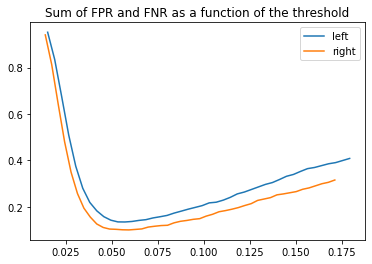

In [411]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""

"""
LEFT FINGER
"""
columns_list = ['fpr_li', 'fnr_li']
#sum of fpr and fnr
sum_fpr_fnr_li = df_to_find_EER_li[columns_list].sum(axis=1)
#find row where the sum FPR + FNR is minimal
threshold_min_fpr_fnr_li_row = sum_fpr_fnr_li.idxmin()
#find corresponding threshold
threshold_min_fpr_fnr_li = df_to_find_EER_li.iloc[threshold_min_fpr_fnr_li_row]["thresholds_li"]
"""
RIGHT FINGER
"""
columns_list = ['fpr_ri', 'fnr_ri']
#sum of fpr and fnr
sum_fpr_fnr_ri = df_to_find_EER_ri[columns_list].sum(axis=1)
#find row where the sum FPR + FNR is minimal
threshold_min_fpr_fnr_ri_row = sum_fpr_fnr_ri.idxmin()
#find corresponding threshold
threshold_min_fpr_fnr_ri = df_to_find_EER_ri.iloc[threshold_min_fpr_fnr_ri_row]["thresholds_ri"]


table = BeautifulTable()
table.rows.append([threshold_min_fpr_fnr_li])
table.rows.append([threshold_min_fpr_fnr_ri])
table.rows.header = ["Left Finger", "Right Finger"]
table.columns.header = ["Decision threshold for which the sum FRR + FAR is minimal "]
print(table)


#Let's also plot the sum to verify visually 


plt.plot(thresholds_li,sum_fpr_fnr_li,label = "left" )
plt.plot(thresholds_ri,sum_fpr_fnr_ri,label="right" )
plt.title("Sum of FPR and FNR as a function of the threshold")
plt.legend()



#### 5. Evaluation using Precision and Recall

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)
[3]: <https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision> (Average precision)

In a general binary classification setting, one also often presents Precision-Recall curves. PR-curves are sometimes summarized using the [average precision scores][3]. How and when to use ROC or PRC is discussed [here][2]. A more general discussion of these measures is provided [here](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c).  

Scikit-Learn provides routines for calculating these curves and numbers as demonstrated in the code below from this [link][2], it also provides an implementation of the [average precision scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score).


<div class="alert alert-block alert-success">
<b>Q5: </b> Precision-Recall curves and related summary measures
<ul>
    <li>Calculate and plot the Precision-Recall curve for this system. What does it reveal about the performance of the system?</li>
    <li>Calculate the Area Under the PR-curve. Discuss.</li>
    <li>Calculate the average precision scores. Discuss its value.</li> 
</ul>  
</div>


Text(0, 0.5, 'Precision')

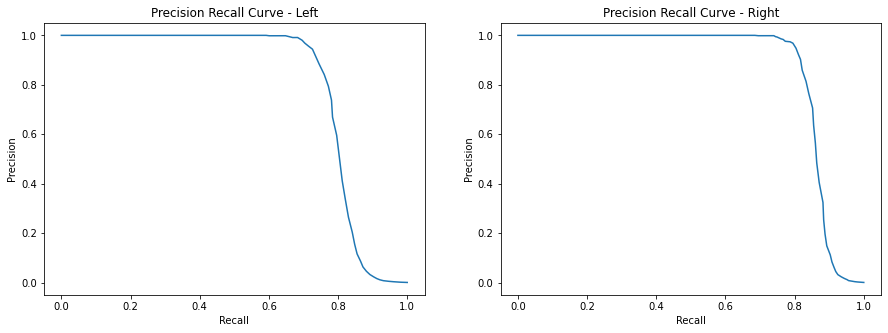

In [105]:
"""Calculate and plot the Precision-Recall curve for this system"""

fig, axis = plt.subplots(1,2,figsize=(15,5))

"""
LEFT FINGER
"""
PR_precision_li, PR_recall_li, PR_thresholds_li = metrics.precision_recall_curve(y_true_li,y_score_li)

axis[0].plot(PR_recall_li,PR_precision_li) 
axis[0].title.set_text("Precision Recall Curve - Left") 
axis[0].set_xlabel('Recall')
axis[0].set_ylabel('Precision')

"""
RIGHT FINGER
"""
PR_precision_ri, PR_recall_ri, PR_thresholds_ri = metrics.precision_recall_curve(y_true_ri,y_score_ri)

axis[1].plot(PR_recall_ri,PR_precision_ri) 
axis[1].title.set_text("Precision Recall Curve - Right") 
axis[1].set_xlabel('Recall')
axis[1].set_ylabel('Precision')

In [107]:
"""Calculate the Area Under the PR-curve."""
# metric.auc is a function to do it 

PR_auc_li = metrics.auc(PR_recall_li, PR_precision_li)
PR_auc_ri = metrics.auc(PR_recall_ri, PR_precision_ri)

table = BeautifulTable()
table.rows.append([PR_auc_li])
table.rows.append([PR_auc_ri])
table.rows.header = ["Left Finger", "Right Finger"]
table.columns.header = ["PR AUC"]
print(table)

+--------------+--------+
|              | PR AUC |
+--------------+--------+
| Left Finger  | 0.803  |
+--------------+--------+
| Right Finger | 0.863  |
+--------------+--------+


In [109]:
"""Calculate the average precision scores"""

average_precision_li = metrics.average_precision_score(y_true_li, y_score_li)
average_precision_ri = metrics.average_precision_score(y_true_ri, y_score_ri)

table = BeautifulTable()
table.rows.append([average_precision_li])
table.rows.append([average_precision_ri])
table.rows.header = ["Left Finger", "Right Finger"]
table.columns.header = ["Average Precision"]
print(table)

+--------------+-------------------+
|              | Average Precision |
+--------------+-------------------+
| Left Finger  |       0.799       |
+--------------+-------------------+
| Right Finger |       0.86        |
+--------------+-------------------+


## III. Validation of identification system 

### Evaluation using CMC curves
In an identification scenario one has a 1-to-many or multi-class classification problem. The performance of such a system is typically measured by the Cumulative Match Characteristic (CMC) curve. This curve plots the experimental probability that a correct identification is returned within the top-x (x=1, ..., N) ranked matching scores. 

<img src="img/CMC.jpg" width="500" height="auto"/>

[Bolle et al.](https://ieeexplore.ieee.org/document/1544394) show that:
> the CMC is also related to the FAR and FRR of a 1:1 matcher, i.e., the matcher that is used to rank the candidates by sorting the scores. This has as a consequence that when a 1:1 matcher is used for identification, that is, for sorting match scores from high to low, the CMC does not offer any additional information beyond the FAR and FRR curves. The CMC is just another way of displaying the data and can be computed from the FAR and FRR.

This paper is not mandatory but those interested can have a look at it.

CMC curves can easily be generated once you have the ranked matching scores for every test sample. In our example we can easily calculate it from the similarity matrix (note that in this very particular case we have only one genuine pair per test sample). 



<div class="alert alert-block alert-success">
<b>Q6: </b> CMC curves
<ul>
    <li>Calculate the Cumulative Matching Characteristic curve (implement this yourself)</li>
    <li>Compute the Rank-1 Recognition Rate.</li>
</ul>  
</div>


In [213]:
"""Calculate the Cumulative Matching Characteristic curve."""
# Hint: don't use a library

#to print full dataframe, use following code :
#display(HTML(li_similarity_matrix.to_html()))

#in the li_similarity_matrix and ri_similarity_matrix dataframe, we have the similarity score between different subjects
#for example, we can see that the in the first row, the subject 11173 has a similarity score of 48.0 with himself (11173),
#and a similarity score of 4.0 with the subject 61011
li_similarity_matrix


,11173,61011,252763,104335,120817,212803,220990,155031,07490,79831,...,120252,15178,252210,230790,55363,27997,46808,27629,258358,49868
subject_id,,,,,,,,,,,,,,,,,,,,,
11173,48.0,4.0,5.0,7.0,9.0,5.0,9.0,4.0,9.0,6.0,...,8.0,10.0,6.0,6.0,5.0,9.0,9.0,4.0,9.0,7.0
61011,5.0,71.0,6.0,7.0,10.0,5.0,4.0,4.0,6.0,5.0,...,6.0,6.0,8.0,6.0,8.0,4.0,12.0,6.0,7.0,6.0
252763,9.0,5.0,17.0,8.0,7.0,8.0,7.0,4.0,6.0,9.0,...,5.0,5.0,8.0,4.0,8.0,7.0,7.0,8.0,6.0,4.0
104335,8.0,6.0,9.0,11.0,5.0,5.0,5.0,5.0,6.0,3.0,...,7.0,8.0,5.0,11.0,6.0,4.0,5.0,11.0,5.0,4.0
120817,11.0,5.0,4.0,5.0,99.0,7.0,7.0,6.0,10.0,3.0,...,8.0,8.0,10.0,7.0,10.0,6.0,12.0,11.0,5.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27997,9.0,4.0,5.0,5.0,6.0,8.0,16.0,5.0,4.0,6.0,...,11.0,7.0,6.0,4.0,10.0,36.0,6.0,8.0,12.0,4.0
46808,3.0,5.0,7.0,8.0,4.0,5.0,4.0,0.0,4.0,3.0,...,7.0,6.0,5.0,6.0,5.0,6.0,41.0,7.0,8.0,4.0
27629,6.0,3.0,4.0,5.0,8.0,4.0,4.0,4.0,3.0,6.0,...,4.0,5.0,3.0,3.0,3.0,5.0,4.0,19.0,3.0,6.0


In [333]:
"""
LEFT FINGER
"""


#number of row
matrix_length_li = len(li_similarity_matrix.index)
#dataframe of recognized or not : if recognized, value = 1. Else, value = 0 
#the columnn is for the rank : from 0 to 1
#the row is for the particular subject_id
#so, for example, if at row 1 and rank 1, the value is 1, it means that it has been recognized
recognized_df_li = pd.DataFrame()

#first for loop to get through all row
#second for loop to test for rank from 1 to 50

for i in range(0,matrix_length_li):
    #we sort the row "i", from higher similarity to lower
    li_similarity_matrix_sorted = li_similarity_matrix.iloc[i].to_frame().sort_values(
        by=list(li_similarity_matrix.iloc[i].to_frame().columns),axis=0,ascending=False).transpose()
    #we save the subject id
    subject_id_li = li_similarity_matrix_sorted.index[0]
    #this list if for the "j" id with highest similarities 
    highest_similarities_id_li  = []
    for j in range(1,1001):
        #for each "j", we append the highest similarity id
        #this list will then accumulates as "j" grows
        highest_similarities_id_li.append(li_similarity_matrix_sorted.columns[j-1])
        #if the subject id is in the list, we set the value of the corresponding dataframe cell to 1
        if subject_id_li in highest_similarities_id_li:
            recognized_df_li.at[i,j] =  1
        else:
            recognized_df_li.at[i,j] =  0

#we can now sum over all rows (subject_id)
#by dividing by matrix_length, we should get the recognition rate
recognition_rate_li = recognized_df_li.sum(axis=0)/matrix_length_li
print(recognition_rate_li)

1       0.836
2       0.854
3       0.859
4       0.863
5       0.870
        ...  
996     1.000
997     1.000
998     1.000
999     1.000
1000    1.000
Length: 1000, dtype: float64


In [334]:
"""
RIGHT FINGER
"""


#number of row
matrix_length_ri = len(ri_similarity_matrix.index)
#dataframe of recognized or not : if recognized, value = 1. Else, value = 0 
#the columnn is for the rank : from 0 to 1
#the row is for the particular subject_id
#so, for example, if at row 1 and rank 1, the value is 1, it means that it has been recognized
recognized_df_ri = pd.DataFrame()

#first for loop to get through all row
#second for loop to test for rank from 1 to 50

for i in range(0,matrix_length_ri):
    #we sort the row "i", from higher similarity to lower
    ri_similarity_matrix_sorted = ri_similarity_matrix.iloc[i].to_frame().sort_values(
        by=list(ri_similarity_matrix.iloc[i].to_frame().columns),axis=0,ascending=False).transpose()
    #we save the subject id
    subject_id_ri = ri_similarity_matrix_sorted.index[0]
    #this list if for the "j" id with highest similarities 
    highest_similarities_id_ri  = []
    for j in range(1,1001):
        #for each "j", we append the highest similarity id
        #this list will then accumulates as "j" grows
        highest_similarities_id_ri.append(ri_similarity_matrix_sorted.columns[j-1])
        #if the subject id is in the list, we set the value of the corresponding dataframe cell to 1
        if subject_id_ri in highest_similarities_id_ri:
            recognized_df_ri.at[i,j] =  1
        else:
            recognized_df_ri.at[i,j] =  0

#we can now sum over all rows (subject_id)
#by dividing by matrix_length, we should get the recognition rate
recognition_rate_ri = recognized_df_ri.sum(axis=0)/matrix_length_ri
print(recognition_rate_ri)

1       0.890
2       0.898
3       0.906
4       0.913
5       0.915
        ...  
996     1.000
997     1.000
998     1.000
999     1.000
1000    1.000
Length: 1000, dtype: float64


Text(0, 0.5, 'Recognition Rate')

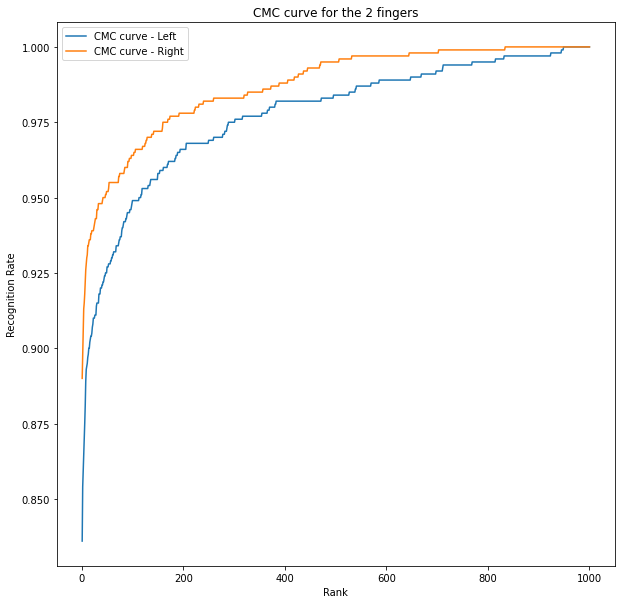

In [335]:
fig, axis = plt.subplots(1,1,figsize=(10,10))
axis.plot(np.arange(1, 1001), recognition_rate_li, label='CMC curve - Left')
axis.plot(np.arange(1, 1001), recognition_rate_ri, label='CMC curve - Right')
axis.title.set_text("CMC curve for the 2 fingers") 
axis.legend()
axis.set_xlabel('Rank')
axis.set_ylabel('Recognition Rate')

# plt.plot(np.arange(1, 81), recognition_rate_li, label='left')
# plt.plot(np.arange(1, 81), recognition_rate_ri, label='right')

In [378]:
""" compute rank 1 recognition rate """

rank_1_recognition_rate_ri = recognition_rate_ri[1]
rank_1_recognition_rate_li = recognition_rate_li[1]


table = BeautifulTable()
table.rows.append([rank_1_recognition_rate_li])
table.rows.append([rank_1_recognition_rate_ri])
table.rows.header = ["Left Finger", "Right Finger"]
table.columns.header = ["Rank 1 recognition rate"]
print(table)

+--------------+-------------------------+
|              | Rank 1 recognition rate |
+--------------+-------------------------+
| Left Finger  |          0.836          |
+--------------+-------------------------+
| Right Finger |          0.89           |
+--------------+-------------------------+


<div class="alert alert-block alert-success">
<b>Q7: </b> Evaluate different biometric systems
<ul>
    <li>Use above evaluation techniques to compare the biometric system based on the left index to the right index </li>
    <li>Do you see any differences in any of the curves or measures?</li>
</ul>  
</div>

## IV. Assignment Instructions
For this assignment you have to submit a report (.pdf) and the implementation of this notebook (.ipynb) to toledo. The report should be between 3-8 pages (more pages $\nRightarrow$ higher score) and should be structured around the posed questions (Q1,...). The text should demonstrate your understanding of the material and, depending on the question, clearly introduce the context, technique, your expectation and interpretation of the results. Do not limit yourselves to just answering the questions. Feel free to add figures and, if needed, some *small* code snippet to clarify your position. **The report should be self contained, the notebook functions as supplementary material only!**

*Note: Make sure you include all the files required to run the notebooks on submission.* <br>
